<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_STL_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분해법(Decomposition Method)

# 전체 아이디어

* **가정(로그-가법 모형)**

  $$\log y_t ;=; T_t ;+; S_t ;+; R_t$$
  
  월별 로그가격을 **추세 (T_t)**, **계절성 (S_t)**, **잔차 (R_t)**로 STL로 분해하고,

  * $(T_t)$: 간단히 **선형회귀로 직선 외삽**
  * $(S_t)$: **마지막 1년(12개월) 패턴을 반복**(seasonal-naive)
  * $(R_t)$: 보수적으로 **0**(평균)으로 둠
      
   합쳐서 $$\hat{\log y}*{t+h}=\hat T*{t+h}+\hat S_{t+h}$$ → **지수변환**으로 가격 예측.

왜 로그? 주가처럼 **곱셈적 계절성/변동성 불균등**을 완화하고, **STL(가법)**과 잘 맞춰주기 위해서.


# 코드 흐름

## 1) 데이터 준비

* `yfinance`에서 **조정종가**를 가져와 **월말(M)**로 리샘플.
* `y_log = log(price)` (이름 충돌 오류 방지를 위해 `y_log.name`으로 이름 지정).

## 2) STL 분해

```python
stl = STL(y_log, period=12, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid
```

* **period=12**: 월데이터의 연간 계절성.
* **robust=True**: 이상치의 영향 완화.



[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-267526713.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m = px.resample(freq).last().dropna()


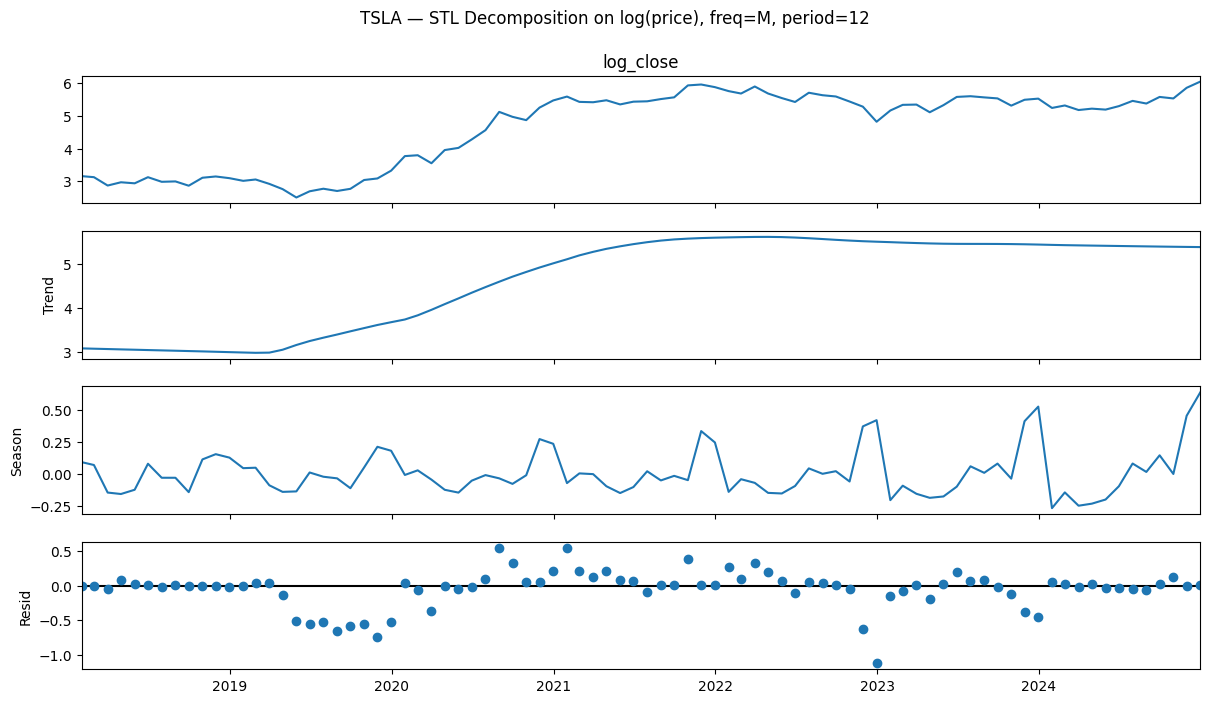

In [1]:
# %pip -q install yfinance statsmodels scikit-learn

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import STL

plt.rcParams["figure.figsize"] = (12, 5)

symbol     = "TSLA"
start_date = "2018-01-01"
end_date   = "2024-12-31"

px = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)

# 월말 리샘플
freq   = "M"
period = 12
px_m = px.resample(freq).last().dropna()

# 🔧 여기만 바꿨습니다
y_log = np.log(px_m["Close"].astype(float))
y_log.name = "log_close"

# STL 분해
stl = STL(y_log, period=period, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid

fig = res.plot(); fig.set_size_inches(12, 7)
plt.suptitle(f"{symbol} — STL Decomposition on log(price), freq={freq}, period={period}", y=1.02)
plt.show()




## 3) 학습/테스트 분리(80/20)

* 월 단위 시계열을 시간순으로 분리해서 **데이터 누수 방지**.

## 4) 구성요소 예측

* **추세 (T)**: `LinearRegression`으로 직선 적합 → 미래 (h)개월 외삽.
* **계절 (S)**: 마지막 12개월 값을 **차례로 반복**.
  시작 월을 맞추기 위해 `start_pos = (마지막 학습월 + 1) % 12`.
* **잔차 (R)**: 0으로 둠(간단 기준). *고도화 시 ARIMA/ETS로 모델링 가능.*

## 5) 합성·역변환·평가

* $(\hat{\log y})$ = 추세 + 계절 → `np.exp`로 **가격**으로 복원.
* 테스트 구간에서 **RMSE / MAE / R²** 계산.
* 실제 vs 예측 **오버레이 플롯** 및 **STL 구성요소 플롯** 출력.



[Decomposition forecast] RMSE=605.8435 | MAE=556.4586 | R2=-98.1023


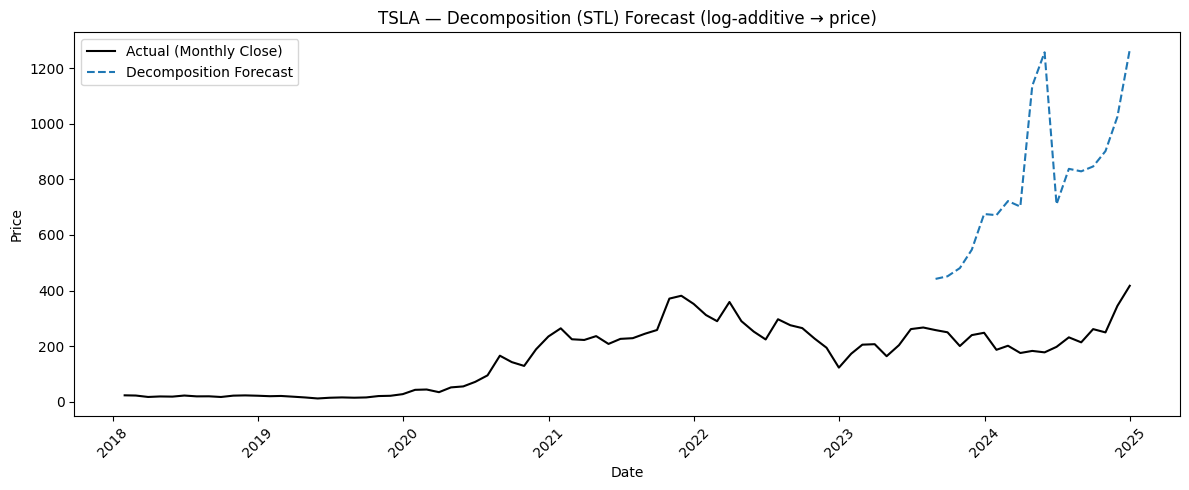

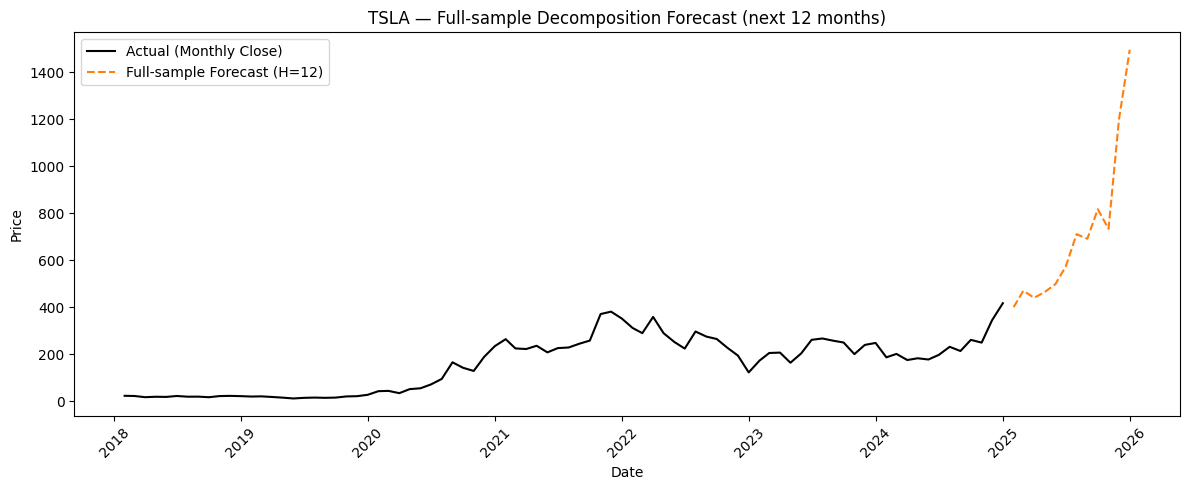

In [6]:
# -----------------------------
# 3) 학습/테스트 분할 (80/20)
# -----------------------------
n = len(y_log)
split = int(n * 0.8)
y_train, y_test = y_log.iloc[:split], y_log.iloc[split:]
trend_train, seasonal_train = trend.iloc[:split], seasonal.iloc[:split]

dates_train = y_train.index
dates_test  = y_test.index

# -----------------------------
# 4) 간단한 예측 전략
# (a) 추세: 선형회귀로 추세 성분 외삽
# (b) 계절성: 학습 구간의 마지막 'period' 패턴 반복
# 잔차는 평균 0 가정
# -----------------------------

def forecast_trend_linear(trend_series, h):
    """추세 성분을 선형회귀로 외삽."""
    t = np.arange(len(trend_series)).reshape(-1, 1)
    lr = LinearRegression().fit(t, trend_series.values)
    t_future = np.arange(len(trend_series), len(trend_series) + h).reshape(-1, 1)
    return lr.predict(t_future)

def repeat_last_season(seasonal_series, period, h, start_idx=0):
    """
    마지막 'period' 계절 패턴을 그대로 반복.
    start_idx=0이면 바로 다음 스텝부터 pattern[0]이 배치됨.
    """
    if len(seasonal_series) < period:
        # 데이터가 짧으면 평균치로 대체
        return np.full(h, seasonal_series.mean(), dtype=float)
    last = seasonal_series.values[-period:]
    out = np.empty(h, dtype=float)
    for i in range(h):
        out[i] = last[(start_idx + i) % period]
    return out

# 테스트 구간 길이
h = len(y_test)

# (a) 추세 예측
trend_fcst = forecast_trend_linear(trend_train, h)

# (b) 계절 예측 (달력 정렬: 테스트 시작 달의 "계절 포지션" 맞추기)
# 학습 구간의 마지막 인덱스가 season의 어디였는지 계산
# 월별(period=12) 가정: 월 번호를 써서 정렬
def month_pos(idx): return idx.month - 1  # 0..11
start_pos = (month_pos(dates_train[-1]) + 1) % period
season_fcst = repeat_last_season(seasonal_train, period, h, start_idx=start_pos)

# (c) 로그 예측 = 추세 + 계절 (+ 잔차 0)
log_fcst = trend_fcst + season_fcst

# (d) 원단위(가격)로 복원
price_test = px_m["Close"].iloc[split:]
price_fcst = np.exp(log_fcst)

# -----------------------------
# 5) 성능 평가 & 시각화
# -----------------------------
rmse = np.sqrt(mean_squared_error(price_test.values, price_fcst))
mae  = mean_absolute_error(price_test.values, price_fcst)
r2   = r2_score(price_test.values, price_fcst)
print(f"[Decomposition forecast] RMSE={rmse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")

plt.figure(figsize=(12,5))
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(dates_test, price_fcst, label="Decomposition Forecast", linestyle="--", color="tab:blue")
plt.title(f"{symbol} — Decomposition (STL) Forecast (log-additive → price)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 6) Full-sample 최종 적합 → 미래 H개월 예측
# -----------------------------
H = 12  # 예: 12개월
stl_full = STL(y_log, period=period, robust=True).fit()
trend_full, seasonal_full = stl_full.trend, stl_full.seasonal

trend_future  = forecast_trend_linear(trend_full, H)

# 미래 시작 달(학습 마지막 달 다음달)의 계절 포지션
start_pos_full = (month_pos(y_log.index[-1]) + 1) % period
season_future = repeat_last_season(seasonal_full, period, H, start_idx=start_pos_full)

log_future = trend_future + season_future
price_future = np.exp(log_future)

future_idx = pd.date_range(y_log.index[-1] + pd.offsets.MonthEnd(1), periods=H, freq="ME")

plt.figure(figsize=(12,5))
plt.plot(px_m.index, px_m["Close"], label="Actual (Monthly Close)", color="black")
plt.plot(future_idx, price_future, label=f"Full-sample Forecast (H={H})", linestyle="--", color="tab:orange")
plt.title(f"{symbol} — Full-sample Decomposition Forecast (next {H} months)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()



# 핵심 함수(요지)

* `forecast_trend_linear`: 추세에 **직선**을 적합해 미래 $(h)$ 스텝 예측.
* `repeat_last_season`: 마지막 **12개월 계절패턴**을 그대로 반복.
* (선택) 잔차를 따로 모델링하면 정밀도가 더 좋아질 수 있어요.



# 자주 묻는 질문(FAQ)

**Q1. 계절성이 약한 주가에도 유효한가요?**

* 강한 ‘캘린더’ 패턴이 없을 수 있어 성능이 제한될 수 있습니다. 그럴 땐 **STL의 trend만 쓰고 seasonal은 0**으로 두거나, **잔차에 ARIMA/SARIMA**를 얹어 보세요.

**Q2. 일봉으로 하고 싶다면?**

* `period=5`(주중 거래일), 또는 `B`(영업일) 기준. 다만 휴장/이벤트로 주기성이 흔들릴 수 있어 월/주 리샘플이 안정적입니다.

**Q3. 왜 로그인가요?**

* **변동성 안정화**와 **곱셈적 계절성 → 가법화** 효과. 예측 후 `exp`로 되돌립니다.

**Q4. 단순 반복 대신 더 똑똑한 계절 예측은?**

* 최근 몇 년의 같은 달 평균, Holt-Winters(ETS)의 계절 성분, 또는 TBATS/Prophet 같은 방법으로 대체 가능합니다.



# 확장 아이디어

* **Fixed-origin / Rolling / Expanding** 백테스트로 평가(원점 이동).
* 잔차 $(R_t)$를 ARIMA/SARIMA로 예측해 $(\hat{T}+\hat{S}+\hat{R})$ 구성.
* **비선형 추세**$(spline/LOESS)$ 외삽, **Regressor**(거래량, 금리 등) 추가.